In [394]:
import pandas as pd
import numpy as np
import time
import math
import talib
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import keras
import matplotlib.pyplot as plt
import tejapi
import datetime
from keras.callbacks import EarlyStopping 
import random
%matplotlib inline  

# 讀取資料

In [2]:
fund_data = pd.read_csv("fundNav.csv")

In [3]:
fund_data.head()

,基金碼,簡稱,年月日,原幣值
0,AIZ19,柏瑞日本小A3,20131101,3516.8416
1,AIZ25,柏瑞美研增Ya$,20131101,122.1093
2,AIZ26,柏瑞歐研增Ya$,20131101,295.4282
3,AIZ29,柏瑞歐研增Aa$,20131101,20.6054
4,AIZ33,柏瑞日小股Y3,20131101,3931.6108


In [4]:
fund_data.columns = ['code', 'name', 'date', 'price']

In [5]:
code_new = []
for i in range(len(fund_data)):
    code_new.append(fund_data["code"][i].strip())

In [6]:
fund_data["code"] = code_new

In [7]:
unique_code = np.unique(fund_data["code"])

In [8]:
len(unique_code)

500

In [9]:
fund_data["code"][0]

'AIZ19'

# 從TEJ抓資料

### 挑出下市的基金

In [10]:
tejapi.ApiConfig.api_key = "DpLFP4HmlmAzovoMVUlZpICUNj6I7P"

In [11]:
stop_fund = tejapi.get("TWN/AOFATT", coid = unique_code, opts={'columns':'coid,' 'zstop_d'})

In [12]:
stop_index = []
for i in range(len(stop_fund)):
    non_stop = stop_fund["zstop_d"].values[0]
    if stop_fund["zstop_d"].values[i] != non_stop:
        stop_index.append(i)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: In the future, NAT != NAT will be True rather than False.
  after removing the cwd from sys.path.


In [13]:
stop_code = stop_fund["coid"][stop_index].values

In [14]:
stop_code

array(['ISZG6', 'ISZF0', 'ISZA0', 'ISZ98', 'ISZ94', 'AEBB0', 'AEBA0',
       'AEB96', 'AEB91', 'AEB70'], dtype=object)

In [15]:
revise_unique_code = []
for i in range(len(unique_code)):
    for j in range(len(stop_code)):
        if unique_code[i] == stop_code[j]:
            loop_stop = 1
    if loop_stop != 1:
        revise_unique_code.append(unique_code[i])
    loop_stop = 0

In [16]:
len(revise_unique_code)

490

# 分群

In [17]:
group_fund_data = fund_data.groupby("code")

In [18]:
test = group_fund_data.get_group(revise_unique_code[0])

In [19]:
test.head()

,code,name,date,price
148,AFZ06,鋒裕全通膨連SE,20131104,114.61
433,AFZ06,鋒裕全通膨連SE,20131105,114.09
723,AFZ06,鋒裕全通膨連SE,20131106,114.28
1013,AFZ06,鋒裕全通膨連SE,20131107,114.47
1303,AFZ06,鋒裕全通膨連SE,20131108,113.74


# 將500檔基金的日期合併(以日期最多的基金為基準)

### 先找出日期最多的基金

In [20]:
max_len = len(group_fund_data.get_group(revise_unique_code[0]))
max_len_index = 0
for i in range(1,490):
    loop_len = len(group_fund_data.get_group(revise_unique_code[i]))
    if(loop_len > max_len):
        max_len = loop_len
        max_len_index = i

In [21]:
max_len

1407

In [22]:
max_len_index

477

### 將第93檔基金放到unique_code的第一個，依序將其他放入

In [23]:
revise_unique_code2 = []
revise_unique_code2.append(revise_unique_code[477])

In [24]:
for i in range(0,477):
    revise_unique_code2.append(revise_unique_code[i])
for i in range(478,490):
    revise_unique_code2.append(revise_unique_code[i])

In [25]:
revise_unique_code2[0:5]

['UBA17', 'AFZ06', 'AIZ19', 'AIZ25', 'AIZ26']

In [26]:
len(revise_unique_code2)

490

### 以第93檔基金的日期做為基準，並合併

In [27]:
outside_data = group_fund_data.get_group(revise_unique_code2[0])
outside_data.index = outside_data.date
outside_data = outside_data.iloc[:,3:4]
outside_data.columns = [revise_unique_code2[0]]

In [28]:
outside_data.head()

,UBA17
date,
20131105,1099.0
20131106,1116.0
20131107,1113.0
20131108,1108.0
20131109,1108.0


In [29]:
for i in range(1, len(revise_unique_code2)):
    loop_data = group_fund_data.get_group(revise_unique_code2[i])
    loop_data.index = loop_data.date
    loop_data = loop_data.iloc[:,3:4]
    loop_data.columns = [revise_unique_code2[i]]
    outside_data = pd.concat([outside_data, loop_data], axis=1, join_axes=[outside_data.index])

In [30]:
merge_fund_data = outside_data

In [31]:
merge_fund_data["date"] = merge_fund_data.index

In [32]:
merge_fund_data.index = range(0, len(merge_fund_data))

In [33]:
date_revise = []
for i in range(len(merge_fund_data)):
    date_revise.append(datetime.datetime.strftime(datetime.datetime.strptime(str(merge_fund_data["date"][i]), "%Y%m%d"), "%Y-%m-%d"))
merge_fund_data.index = date_revise

In [34]:
merge_fund_data.head(5)

,UBA17,AFZ06,AIZ19,AIZ25,AIZ26,AIZ29,AIZ33,AIZ56,AIZ57,AIZ62,...,UOB22,UOB26,UOB40,UOB41,VON06,VON10,VON18,VON23,VON25,date
2013-11-05,1099.0,114.09,3536.3005,122.2801,295.8842,20.6363,3953.5381,15.9421,165.7173,130.0218,...,2.557,2.055,1.054,1.930,68.76,75.77,193.23,152.06,117.90,20131105
2013-11-06,1116.0,114.28,3531.7229,122.5995,298.3029,20.8046,3948.5110,16.0192,166.5209,129.8848,...,2.541,2.045,1.051,1.943,68.87,76.19,193.94,152.83,117.96,20131106
2013-11-07,1113.0,114.47,3532.8955,120.9063,295.1083,20.5813,3949.9065,15.8264,164.5181,129.6473,...,2.522,2.024,1.051,1.936,69.19,75.72,190.65,152.39,118.02,20131107
2013-11-08,1108.0,113.74,3518.3689,122.6620,293.8962,20.4954,3933.9346,16.0544,166.8950,128.3850,...,2.567,2.058,1.046,1.932,68.79,75.09,193.06,151.01,117.97,20131108
2013-11-09,1108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20131109


### 整理成週資料(開高收低)

In [39]:
revise_merge_data = pd.DataFrame(columns=["code", "start_date", "end_date", "open", "high", "close", "low"])
for j in range(len(revise_unique_code2)):
    revise_data = pd.concat([merge_fund_data.iloc[:,j:j+1], merge_fund_data["date"]], axis=1)
    ## 第一週
    range_data = revise_data.loc["2013-11-05":"2013-11-10"]
    range_data.index = range(len(range_data))
    revise_open = range_data.iloc[:,0:1].values[0][0]
    revise_close = range_data.iloc[:,0:1].values[len(range_data)-1][0]
    if str(revise_open) == "nan":
        for i in range(1,len(range_data)):
            revise_open = revise_data.iloc[:,0:1].values[i][0]
    revise_high = revise_open
    revise_low = revise_open
    for i in range(1,len(range_data)):
        if str(revise_close) == "nan":
            revise_close = revise_data.iloc[:,0:1].values[len(range_data)-1-i][0]
        if revise_data.iloc[:,0:1].values[i][0] > revise_high:
            revise_high = revise_data.iloc[:,0:1].values[i][0]
        if revise_data.iloc[:,0:1].values[i][0] < revise_low:
            revise_low = revise_data.iloc[:,0:1].values[i][0]
    revisedata_dict = {
        "code":revise_data.columns[0],
        "start_date":datetime.datetime.strftime(datetime.datetime.strptime(str(merge_fund_data["date"][0]), "%Y%m%d"), "%Y-%m-%d"),
        "end_date":datetime.datetime.strftime(datetime.datetime.strptime(str(merge_fund_data["date"][len(range_data)-1]), "%Y%m%d"), "%Y-%m-%d"),
        "open": revise_open,
        "high": revise_high,
        "close":revise_close,
        "low":revise_low
    }
    revise_merge_data = pd.concat([revise_merge_data, pd.DataFrame(revisedata_dict, index=[0])], axis=0)
    ## 後面所有的週
    for ix in range(0, 262):
        start_date = datetime.datetime.strptime(str(merge_fund_data["date"][6]), "%Y%m%d") + datetime.timedelta(days=ix*7)
        start_date = datetime.datetime.strftime(start_date, "%Y-%m-%d")
        end_date = datetime.datetime.strptime(str(merge_fund_data["date"][12]), "%Y%m%d") + datetime.timedelta(days=ix*7)
        end_date = datetime.datetime.strftime(end_date, "%Y-%m-%d")
        range_data = revise_data.loc[start_date:end_date]
        range_data.index = range(len(range_data))
        revise_open = range_data.iloc[:,0:1].values[0][0]
        revise_close = range_data.iloc[:,0:1].values[len(range_data)-1][0]
        if str(revise_open) == "nan":
            for i in range(1,len(range_data)):
                revise_open = range_data.iloc[:,0:1].values[i][0]
        revise_high = revise_open
        revise_low = revise_open
        for i in range(1,len(range_data)):
            if str(revise_close) == "nan":
                revise_close = range_data.iloc[:,0:1].values[len(range_data)-1-i][0]
            if range_data.iloc[:,0:1].values[i][0] > revise_high:
                revise_high = range_data.iloc[:,0:1].values[i][0]
            if range_data.iloc[:,0:1].values[i][0] < revise_low:
                revise_low = range_data.iloc[:,0:1].values[i][0]
        revisedata_dict = {
            "code":revise_data.columns[0],
            "start_date":start_date,
            "end_date":end_date,
            "open": revise_open,
            "high": revise_high,
            "close":revise_close,
            "low":revise_low
        }
        revise_merge_data = pd.concat([revise_merge_data, pd.DataFrame(revisedata_dict, index=[0])], axis=0)
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [41]:
revise_merge_data.index = range(len(revise_merge_data))

In [43]:
revise_merge_data.to_csv("revise_data.csv", index=False)

# 總經資料

### 石油

In [53]:
oil_data = pd.read_csv("DCOILBRENTEU_1117.csv")

In [54]:
oil_data.columns = ["DATE", "OIL"]

In [59]:
date_oil = []
for i in range(0, len(oil_data["DATE"])):
    date_oil.append(oil_data["DATE"][i].replace('-', ''))

In [63]:
oil_data["DATE"] = date_oil

In [69]:
date_oil = []
for i in range(len(oil_data)):
    date_oil.append(datetime.datetime.strftime(datetime.datetime.strptime(str(oil_data["DATE"][i]), "%Y%m%d"), "%Y-%m-%d"))
oil_data.index = date_oil

In [72]:
oil_data = oil_data.drop(["DATE"], axis=1)

In [73]:
oil_data.head()

,OIL
2013-11-01,105.78
2013-11-04,104.85
2013-11-05,105.01
2013-11-06,105.46
2013-11-07,103.08


### 美國公債十年利率

In [127]:
dgs10_data = pd.read_csv("DGS10_1117.csv") 

In [128]:
date_dgs10 = []
for i in range(0, len(dgs10_data)):
    date_dgs10.append(dgs10_data["observation_date"][i].replace('-', ''))

In [129]:
dgs10_data["DATE"] = date_dgs10

In [132]:
date_dgs10 = []
for i in range(len(dgs10_data)):
    date_dgs10.append(datetime.datetime.strftime(datetime.datetime.strptime(str(dgs10_data["DATE"][i]), "%Y%m%d"), "%Y-%m-%d"))
dgs10_data.index = date_dgs10

In [134]:
dgs10_data = dgs10_data.drop(["observation_date"], axis=1)
dgs10_data = dgs10_data.drop(["DATE"], axis=1)

In [135]:
dgs10_data.head()

,DGS10
2013-11-01,2.65
2013-11-04,2.63
2013-11-05,2.69
2013-11-06,2.67
2013-11-07,2.63


### 合併

In [137]:
basic_data = oil_data

In [138]:
basic_data = pd.concat([basic_data, dgs10_data], axis=1, join_axes=[basic_data.index])

In [145]:
basic_data.head()

,OIL,DGS10
2013-11-01,105.78,2.65
2013-11-04,104.85,2.63
2013-11-05,105.01,2.69
2013-11-06,105.46,2.67
2013-11-07,103.08,2.63


### 整理成週資料

In [150]:
revise_merge_data = pd.DataFrame(columns=["code", "start_date", "end_date", "open", "high", "close", "low"])
for j in range(2):
    revise_data = basic_data.iloc[:,j:j+1]
    ## 第一週
    range_data = revise_data.loc["2013-11-05":"2013-11-10"]
    range_data.index = range(len(range_data))
    revise_open = range_data.iloc[:,0:1].values[0][0]
    revise_close = range_data.iloc[:,0:1].values[len(range_data)-1][0]
    if str(revise_open) == "nan":
        for i in range(1,len(range_data)):
            revise_open = revise_data.iloc[:,0:1].values[i][0]
    revise_high = revise_open
    revise_low = revise_open
    for i in range(1,len(range_data)):
        if str(revise_close) == "nan":
            revise_close = revise_data.iloc[:,0:1].values[len(range_data)-1-i][0]
        if revise_data.iloc[:,0:1].values[i][0] > revise_high:
            revise_high = revise_data.iloc[:,0:1].values[i][0]
        if revise_data.iloc[:,0:1].values[i][0] < revise_low:
            revise_low = revise_data.iloc[:,0:1].values[i][0]
    revisedata_dict = {
        "code":revise_data.columns[0],
        "start_date":datetime.datetime.strftime(datetime.datetime.strptime(str(merge_fund_data["date"][0]), "%Y%m%d"), "%Y-%m-%d"),
        "end_date":datetime.datetime.strftime(datetime.datetime.strptime(str(merge_fund_data["date"][len(range_data)-1]), "%Y%m%d"), "%Y-%m-%d"),
        "open": revise_open,
        "high": revise_high,
        "close":revise_close,
        "low":revise_low
    }
    revise_merge_data = pd.concat([revise_merge_data, pd.DataFrame(revisedata_dict, index=[0])], axis=0)
    ## 後面所有的週
    for ix in range(0, 262):
        start_date = datetime.datetime.strptime(str(merge_fund_data["date"][6]), "%Y%m%d") + datetime.timedelta(days=ix*7)
        start_date = datetime.datetime.strftime(start_date, "%Y-%m-%d")
        end_date = datetime.datetime.strptime(str(merge_fund_data["date"][12]), "%Y%m%d") + datetime.timedelta(days=ix*7)
        end_date = datetime.datetime.strftime(end_date, "%Y-%m-%d")
        range_data = revise_data.loc[start_date:end_date]
        range_data.index = range(len(range_data))
        revise_open = range_data.iloc[:,0:1].values[0][0]
        revise_close = range_data.iloc[:,0:1].values[len(range_data)-1][0]
        if str(revise_open) == "nan":
            for i in range(1,len(range_data)):
                revise_open = range_data.iloc[:,0:1].values[i][0]
        revise_high = revise_open
        revise_low = revise_open
        for i in range(1,len(range_data)):
            if str(revise_close) == "nan":
                revise_close = range_data.iloc[:,0:1].values[len(range_data)-1-i][0]
            if range_data.iloc[:,0:1].values[i][0] > revise_high:
                revise_high = range_data.iloc[:,0:1].values[i][0]
            if range_data.iloc[:,0:1].values[i][0] < revise_low:
                revise_low = range_data.iloc[:,0:1].values[i][0]
        revisedata_dict = {
            "code":revise_data.columns[0],
            "start_date":start_date,
            "end_date":end_date,
            "open": revise_open,
            "high": revise_high,
            "close":revise_close,
            "low":revise_low
        }
        revise_merge_data = pd.concat([revise_merge_data, pd.DataFrame(revisedata_dict, index=[0])], axis=0)
    print(j)

0
1


# 讀取整理完的資料

In [44]:
revise_merge_data = pd.read_csv("revise_data.csv")

In [45]:
group_revise_merge_data = revise_merge_data.groupby("code")

In [46]:
group_revise_merge_data.get_group(revise_unique_code2[0]).head()

,code,start_date,end_date,open,high,close,low
0,UBA17,2013-11-05,2013-11-10,1099.0,1116.0,1108.0,1099.0
1,UBA17,2013-11-11,2013-11-17,1118.0,1163.0,1163.0,1118.0
2,UBA17,2013-11-18,2013-11-24,1163.0,1167.0,1167.0,1157.0
3,UBA17,2013-11-25,2013-12-01,1179.0,1179.0,1179.0,1172.0
4,UBA17,2013-12-02,2013-12-08,1178.0,1178.0,1157.0,1153.0


In [47]:
basic_data = pd.read_csv("revise_mero.csv")

In [48]:
group_basic_data = basic_data.groupby("code")

In [49]:
group_basic_data.get_group("OIL").head()

,code,start_date,end_date,open,high,close,low
0,OIL,2013-11-05,2013-11-08,105.01,105.46,104.29,104.85
1,OIL,2013-11-11,2013-11-17,105.76,108.29,108.25,105.76
2,OIL,2013-11-18,2013-11-24,108.80,111.36,111.36,108.27
3,OIL,2013-11-25,2013-12-01,110.83,112.04,111.07,110.83
4,OIL,2013-12-02,2013-12-08,111.49,113.27,111.50,111.49


# 訓練、測試集資料

### 正規化

In [157]:
def normalize(df):
    newdf= df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    
    newdf['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    newdf['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    newdf['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    newdf['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    newdf['RSI'] = min_max_scaler.fit_transform(df.RSI.values.reshape(-1,1))
    newdf['MA5'] = min_max_scaler.fit_transform(df.MA5.values.reshape(-1,1))
    newdf['MA10'] = min_max_scaler.fit_transform(df.MA10.values.reshape(-1,1))
    newdf['MA20'] = min_max_scaler.fit_transform(df.MA20.values.reshape(-1,1))
    newdf['EMA'] = min_max_scaler.fit_transform(df.EMA.values.reshape(-1,1))
    newdf['CMO'] = min_max_scaler.fit_transform(df.CMO.values.reshape(-1,1))
    newdf['MACD'] = min_max_scaler.fit_transform(df.MACD.values.reshape(-1,1))
    newdf['ROC'] = min_max_scaler.fit_transform(df.ROC.values.reshape(-1,1))
    newdf['WilliamsR'] = min_max_scaler.fit_transform(df.WilliamsR.values.reshape(-1,1))
    newdf['CCI'] = min_max_scaler.fit_transform(df.CCI.values.reshape(-1,1))
    newdf['DMI'] = min_max_scaler.fit_transform(df.DMI.values.reshape(-1,1))
    newdf['oil'] = min_max_scaler.fit_transform(df.oil.values.reshape(-1,1))
    newdf['dgs10'] = min_max_scaler.fit_transform(df.dgs10.values.reshape(-1,1))
    return(newdf)

### 挑出沒有這週的代碼

In [66]:
check_date = group_revise_merge_data.get_group(revise_unique_code2[0]).iloc[[len(group_revise_merge_data.get_group(revise_unique_code2[0]))-1]]

In [67]:
for i in range(1,490):
    check_date = pd.concat([check_date, group_revise_merge_data.get_group(revise_unique_code2[i]).iloc[[len(group_revise_merge_data.get_group(revise_unique_code2[i]))-1]]], axis=0)

In [68]:
check_date.index = range(len(check_date))

In [69]:
check_date = check_date.dropna()

In [72]:
revise_unique_code3 = check_date["code"].values

In [74]:
len(revise_unique_code3)

486

### 計算技術指標以及加入總經因子

In [374]:
def pick_data_train(code):
    fun_data = group_revise_merge_data.get_group(code)
    fun_data = fun_data.dropna()
    fun_data.index = range(len(fun_data))
    fun_data["return"] = (fun_data["close"]-fun_data["open"])/fun_data["open"]
    fun_data["RSI"] = talib.RSI(np.array(fun_data["close"]))
    fun_data["MA5"] = talib.SMA(np.array(fun_data["close"]),5)
    fun_data["MA10"] = talib.SMA(np.array(fun_data["close"]),10)
    fun_data["MA20"] = talib.SMA(np.array(fun_data["close"]),20)
    fun_data["EMA"] = talib.EMA(np.array(fun_data["close"]))
    fun_data["CMO"] = talib.CMO(np.array(fun_data["close"]))
    macd, macdsignal, macdhist = talib.MACD(np.array(fun_data["close"]), fastperiod=12, slowperiod=26, signalperiod=20)
    fun_data["MACD"] = macdhist
    fun_data["ROC"] = talib.ROC(np.array(fun_data["close"]))
    fun_data["WilliamsR"] = talib.WILLR(np.array(fun_data["high"]), 
                                        np.array(fun_data["low"]),
                                        np.array(fun_data["close"]))
    fun_data["CCI"] = talib.CCI(np.array(fun_data["high"]),
                                np.array(fun_data["low"]),
                                np.array(fun_data["close"]))
    fun_data["DMI"] = talib.ADX(np.array(fun_data["high"]),
                                np.array(fun_data["low"]),
                                np.array(fun_data["close"]))
    
    oil_revise_data = group_basic_data.get_group("OIL")[["close"]]
    oil_revise_data.columns = ["oil"]
    dgs10_revise_data = group_basic_data.get_group("DGS10")[["close"]]
    dgs10_revise_data.columns = ["dgs10"]
    dgs10_revise_data.index = range(len(dgs10_revise_data))
    fun_data = pd.concat([fun_data, oil_revise_data], axis=1, join_axes=[fun_data.index])
    fun_data = pd.concat([fun_data, dgs10_revise_data], axis=1, join_axes=[fun_data.index])
    fun_data = fun_data.drop(["code", "start_date", "end_date"], axis=1)
    fun_data["return"] = fun_data["return"].shift(-1)
    fun_data = fun_data[0:round(len(fun_data)*0.8)]
    fun_data = normalize(fun_data.dropna())
    fun_data.index = range(len(fun_data))
    return(fun_data)

In [471]:
def pick_data_test(code):
    fun_data = group_revise_merge_data.get_group(code)
    fun_data = fun_data.dropna()
    fun_data.index = range(len(fun_data))
    fun_data["return"] = (fun_data["close"]-fun_data["open"])/fun_data["open"]
    fun_data["RSI"] = talib.RSI(np.array(fun_data["close"]))
    fun_data["MA5"] = talib.SMA(np.array(fun_data["close"]),5)
    fun_data["MA10"] = talib.SMA(np.array(fun_data["close"]),10)
    fun_data["MA20"] = talib.SMA(np.array(fun_data["close"]),20)
    fun_data["EMA"] = talib.EMA(np.array(fun_data["close"]))
    fun_data["CMO"] = talib.CMO(np.array(fun_data["close"]))
    macd, macdsignal, macdhist = talib.MACD(np.array(fun_data["close"]), fastperiod=12, slowperiod=26, signalperiod=20)
    fun_data["MACD"] = macdhist
    fun_data["ROC"] = talib.ROC(np.array(fun_data["close"]))
    fun_data["WilliamsR"] = talib.WILLR(np.array(fun_data["high"]), 
                                        np.array(fun_data["low"]),
                                        np.array(fun_data["close"]))
    fun_data["CCI"] = talib.CCI(np.array(fun_data["high"]),
                                np.array(fun_data["low"]),
                                np.array(fun_data["close"]))
    fun_data["DMI"] = talib.ADX(np.array(fun_data["high"]),
                                np.array(fun_data["low"]),
                                np.array(fun_data["close"]))
    
    oil_revise_data = group_basic_data.get_group("OIL")[["close"]]
    oil_revise_data.columns = ["oil"]
    dgs10_revise_data = group_basic_data.get_group("DGS10")[["close"]]
    dgs10_revise_data.columns = ["dgs10"]
    dgs10_revise_data.index = range(len(dgs10_revise_data))
    fun_data = pd.concat([fun_data, oil_revise_data], axis=1, join_axes=[fun_data.index])
    fun_data = pd.concat([fun_data, dgs10_revise_data], axis=1, join_axes=[fun_data.index])
    fun_data = fun_data.drop(["code", "start_date", "end_date"], axis=1)
    fun_data["return"] = fun_data["return"].shift(-1)
    fun_data = fun_data[round(len(fun_data)*0.8):len(fun_data)]
    fun_data = normalize(fun_data.dropna())
    fun_data.index = range(len(fun_data))
    return(fun_data)

In [472]:
def pick_plot_data(code):
    fun_data = group_revise_merge_data.get_group(code)
    fun_data = fun_data.dropna()
    fun_data.index = range(len(fun_data))
    fun_data["return"] = (fun_data["close"]-fun_data["open"])/fun_data["open"]
    fun_data["RSI"] = talib.RSI(np.array(fun_data["close"]))
    fun_data["MA5"] = talib.SMA(np.array(fun_data["close"]),5)
    fun_data["MA10"] = talib.SMA(np.array(fun_data["close"]),10)
    fun_data["MA20"] = talib.SMA(np.array(fun_data["close"]),20)
    fun_data["EMA"] = talib.EMA(np.array(fun_data["close"]))
    fun_data["CMO"] = talib.CMO(np.array(fun_data["close"]))
    macd, macdsignal, macdhist = talib.MACD(np.array(fun_data["close"]), fastperiod=12, slowperiod=26, signalperiod=20)
    fun_data["MACD"] = macdhist
    fun_data["ROC"] = talib.ROC(np.array(fun_data["close"]))
    fun_data["WilliamsR"] = talib.WILLR(np.array(fun_data["high"]), 
                                        np.array(fun_data["low"]),
                                        np.array(fun_data["close"]))
    fun_data["CCI"] = talib.CCI(np.array(fun_data["high"]),
                                np.array(fun_data["low"]),
                                np.array(fun_data["close"]))
    fun_data["DMI"] = talib.ADX(np.array(fun_data["high"]),
                                np.array(fun_data["low"]),
                                np.array(fun_data["close"]))
    
    oil_revise_data = group_basic_data.get_group("OIL")[["close"]]
    oil_revise_data.columns = ["oil"]
    dgs10_revise_data = group_basic_data.get_group("DGS10")[["close"]]
    dgs10_revise_data.columns = ["dgs10"]
    dgs10_revise_data.index = range(len(dgs10_revise_data))
    fun_data = pd.concat([fun_data, oil_revise_data], axis=1, join_axes=[fun_data.index])
    fun_data = pd.concat([fun_data, dgs10_revise_data], axis=1, join_axes=[fun_data.index])
    fun_data["return"] = fun_data["return"].shift(-1)
    fun_data = fun_data[round(len(fun_data)*0.8):len(fun_data)]
    fun_data = fun_data.dropna()
    fun_data = fun_data[["code", "start_date", "end_date", "open", "close"]]
    fun_data.index = range(len(fun_data))
    return(fun_data)

In [376]:
pick_train_test_data(revise_unique_code3[0]).head()

,open,high,close,low,return,RSI,MA5,MA10,MA20,EMA,CMO,MACD,ROC,WilliamsR,CCI,DMI,oil,dgs10
0,0.188352,0.185464,0.233533,0.219277,0.012559,0.707236,0.149246,0.083743,0.000000,0.000000,0.707236,0.577637,0.520516,0.935897,0.798156,0.056994,0.993525,0.672043
1,0.204461,0.199248,0.252695,0.225301,-0.001548,0.747637,0.162477,0.093429,0.010272,0.008886,0.747637,0.583963,0.591320,1.000000,0.848808,0.087468,1.000000,0.655914
2,0.226766,0.213033,0.252695,0.246988,-0.043310,0.747637,0.171209,0.102071,0.021470,0.017199,0.747637,0.583547,0.580381,0.884211,0.862668,0.128237,0.975423,0.629032
3,0.228005,0.203008,0.189222,0.186747,-0.040032,0.522825,0.168828,0.099836,0.028122,0.018936,0.522825,0.544969,0.472414,0.326316,0.514572,0.086919,0.912436,0.580645
4,0.173482,0.147870,0.143713,0.144578,-0.044204,0.400504,0.153215,0.092088,0.030226,0.016232,0.400504,0.489848,0.418327,0.000000,0.213839,0.088708,0.880942,0.505376


In [377]:
pick_data_test(revise_unique_code3[0]).head()

,open,high,close,low,return,RSI,MA5,MA10,MA20,EMA,CMO,MACD,ROC,WilliamsR,CCI,DMI,oil,dgs10
0,0.482490,0.381356,0.272,0.280,0.009254,0.554165,0.309368,0.007223,0.000000,0.000000,0.554165,0.888590,0.977341,0.617117,0.556276,0.578944,0.000000,0.011236
1,0.272374,0.237288,0.324,0.280,0.030442,0.597924,0.315904,0.086677,0.040855,0.045656,0.597924,0.828680,0.854598,0.675676,0.520903,0.575861,0.094197,0.000000
2,0.319066,0.427966,0.520,0.296,0.007812,0.745773,0.319172,0.174157,0.099275,0.116194,0.745773,0.839678,0.876253,0.896396,0.604076,0.603955,0.135828,0.033708
3,0.517510,0.478814,0.568,0.488,-0.006037,0.778366,0.333333,0.246388,0.164948,0.188996,0.778366,0.850178,0.817899,0.950450,0.664312,0.637361,0.105971,0.044944
4,0.634241,0.622881,0.588,0.608,0.013143,0.792276,0.344227,0.312199,0.230622,0.259940,0.792276,0.850278,0.793962,0.875536,0.730792,0.687533,0.103869,0.011236


### 建立訓練集與測試集資料

In [392]:
def buildTrain():
    pastDay = 30
    X_train, Y_train = [], []
    for j in range(0, len(revise_unique_code3)):
        fun_data = pick_data_train(revise_unique_code3[j])
        return_data = fun_data[["return"]]
        fun_data = fun_data.drop(["return"], axis=1)
        for i in range(len(fun_data)-pastDay):
            X_train.append(np.array(fun_data.iloc[i:i+pastDay]))
            Y_train.append(np.array(return_data["return"][i+pastDay-1]))
    return np.array(X_train), np.array(Y_train)

In [403]:
random_code_5 = random.sample(range(len(revise_unique_code3)), 5)

In [404]:
random_code_5 = revise_unique_code3[random_code_5]

In [424]:
def buildTest(code):
    pastDay = 30
    X_test, Y_test = [], []
    fun_data = pick_data_test(code)
    return_data = fun_data[["return"]]
    fun_data = fun_data.drop(["return"], axis=1)
    for i in range(len(fun_data)-pastDay):
        X_test.append(np.array(fun_data.iloc[i:i+pastDay]))
        Y_test.append(np.array(return_data["return"][i+pastDay-1]))
    return np.array(X_test), np.array(Y_test)

### 將資料打亂

In [384]:
def shuffle(X, Y):
    np.random.seed(87)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return(X[randomList], Y[randomList])

# 建構模型

In [385]:
## 首先在面前加了一層64個神經元的 LSTM layer，並都加上了Dropout層來防止資料過度擬合（overfitting）。
## 最後再加上兩層有不同數目神經元的全連結層來得到只有1維數值的輸出結果，也就是預測股價

def LSTM_model(shape):
    model = Sequential()
    model.add(LSTM(64, input_length=shape[1], input_dim=shape[2]))
    model.add(Dropout(0.3))
    model.add(Dense(16, kernel_initializer="uniform", activation='relu'))
    model.add(Dense(1, kernel_initializer="uniform", activation='linear'))
    model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
    model.summary()
    return model

# Final
- 建立訓練集資料
- 建立測試集資料
- 打散訓練集資料
- 建立模型
- 模型訓練
- 預測

In [386]:
x_train, y_train = buildTrain()

In [387]:
x_train, y_train = shuffle(x_train, y_train)

In [388]:
model = LSTM_model(x_train.shape)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, input_shape=(30, 17))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                20992     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 22,049
Trainable params: 22,049
Non-trainable params: 0
_________________________________________________________________


In [389]:
train_history = model.fit(x_train,
                          y_train,
                          batch_size=128,
                          epochs=100,
                          validation_split=0.2,
                          verbose=1, 
                          callbacks=[EarlyStopping(patience=10)])

Train on 50693 samples, validate on 12674 samples
Epoch 1/100
50693/50693 [==============================] - 38s 756us/step - loss: 2.6390e-04 - acc: 0.0836 - val_loss: 2.5989e-04 - val_acc: 0.0880
Epoch 2/100
50693/50693 [==============================] - 34s 669us/step - loss: 2.5998e-04 - acc: 0.0836 - val_loss: 2.5509e-04 - val_acc: 0.0880
Epoch 3/100
50693/50693 [==============================] - 34s 666us/step - loss: 2.5778e-04 - acc: 0.0836 - val_loss: 2.5354e-04 - val_acc: 0.0880
Epoch 4/100
50693/50693 [==============================] - 34s 666us/step - loss: 2.5637e-04 - acc: 0.0836 - val_loss: 2.5169e-04 - val_acc: 0.0880
Epoch 5/100
50693/50693 [==============================] - 34s 667us/step - loss: 2.5491e-04 - acc: 0.0836 - val_loss: 2.4935e-04 - val_acc: 0.0880
Epoch 6/100
50693/50693 [==============================] - 34s 664us/step - loss: 2.5227e-04 - acc: 0.0836 - val_loss: 2.4591e-04 - val_acc: 0.0880
Epoch 7/100
50693/50693 [==============================] - 34s

Epoch 56/100
50693/50693 [==============================] - 34s 665us/step - loss: 1.1977e-04 - acc: 0.0836 - val_loss: 1.3042e-04 - val_acc: 0.0880
Epoch 57/100
50693/50693 [==============================] - 34s 665us/step - loss: 1.1705e-04 - acc: 0.0836 - val_loss: 1.4068e-04 - val_acc: 0.0880
Epoch 58/100
50693/50693 [==============================] - 34s 663us/step - loss: 1.1917e-04 - acc: 0.0836 - val_loss: 1.2568e-04 - val_acc: 0.0880
Epoch 59/100
50693/50693 [==============================] - 34s 663us/step - loss: 1.1769e-04 - acc: 0.0836 - val_loss: 1.2745e-04 - val_acc: 0.0880
Epoch 60/100
50693/50693 [==============================] - 34s 668us/step - loss: 1.1868e-04 - acc: 0.0836 - val_loss: 1.3270e-04 - val_acc: 0.0880
Epoch 61/100
50693/50693 [==============================] - 34s 667us/step - loss: 1.2141e-04 - acc: 0.0836 - val_loss: 1.2310e-04 - val_acc: 0.0880
Epoch 62/100
50693/50693 [==============================] - 34s 668us/step - loss: 1.1535e-04 - acc: 0.083

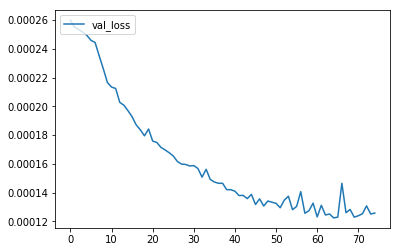

In [536]:
plt.plot(train_history.history['val_loss'], label = "val_loss")
plt.legend(loc='upper left')

### 畫圖

In [575]:
x_test, y_test = buildTest(random_code_5[0])
pred = model.predict(x_test)
plot_data = pick_plot_data(random_code_5[0])[len(pick_plot_data(random_code_5[0]))-len(x_test):len(pick_plot_data(random_code_5[0]))]
plot_data["return"] = pick_data_test(random_code_5[0])["return"][len(pick_plot_data(random_code_5[0]))-len(x_test)-1:len(pick_plot_data(random_code_5[0]))-1].values
plot_data.index = range(len(plot_data))
plot_data["pred"] = pred
plot_data["pred_check"] = (plot_data["close"]-plot_data["open"])/plot_data["open"]
plot_data["pred_close"] = plot_data["close"]*(1+plot_data["pred"])

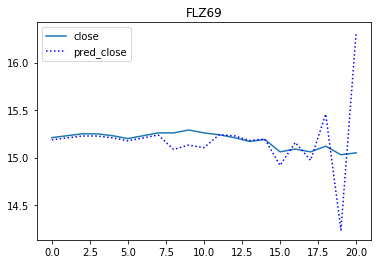

In [576]:
plt.plot(plot_data["close"], label='close')
plt.plot(plot_data["pred_close"], linestyle=':', c='blue', label='pred_close')
plt.title(str(plot_data["code"].values[0]))
plt.legend()

In [577]:
x_test, y_test = buildTest(random_code_5[1])
pred = model.predict(x_test)
plot_data = pick_plot_data(random_code_5[1])[len(pick_plot_data(random_code_5[1]))-len(x_test):len(pick_plot_data(random_code_5[1]))]
plot_data["return"] = pick_data_test(random_code_5[1])["return"][len(pick_plot_data(random_code_5[1]))-len(x_test)-1:len(pick_plot_data(random_code_5[1]))-1].values
plot_data.index = range(len(plot_data))
plot_data["pred"] = pred
plot_data["pred_check"] = (plot_data["close"]-plot_data["open"])/plot_data["open"]
plot_data["pred_close"] = plot_data["close"]*(1+plot_data["pred"])

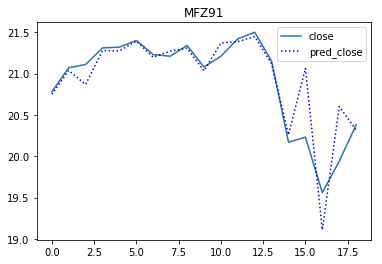

In [578]:
plt.plot(plot_data["close"], label='close')
plt.plot(plot_data["pred_close"], linestyle=':', c='blue', label='pred_close')
plt.title(str(plot_data["code"].values[0]))
plt.legend()

In [579]:
x_test, y_test = buildTest(random_code_5[2])
pred = model.predict(x_test)
plot_data = pick_plot_data(random_code_5[2])[len(pick_plot_data(random_code_5[2]))-len(x_test):len(pick_plot_data(random_code_5[2]))]
plot_data["return"] = pick_data_test(random_code_5[2])["return"][len(pick_plot_data(random_code_5[2]))-len(x_test)-1:len(pick_plot_data(random_code_5[2]))-1].values
plot_data.index = range(len(plot_data))
plot_data["pred"] = pred
plot_data["pred_check"] = (plot_data["close"]-plot_data["open"])/plot_data["open"]
plot_data["pred_close"] = plot_data["close"]*(1+plot_data["pred"])

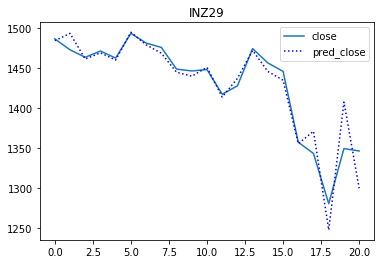

In [580]:
plt.plot(plot_data["close"], label='close')
plt.plot(plot_data["pred_close"], linestyle=':', c='blue', label='pred_close')
plt.title(str(plot_data["code"].values[0]))
plt.legend()

In [581]:
x_test, y_test = buildTest(random_code_5[3])
pred = model.predict(x_test)
plot_data = pick_plot_data(random_code_5[3])[len(pick_plot_data(random_code_5[3]))-len(x_test):len(pick_plot_data(random_code_5[3]))]
plot_data["return"] = pick_data_test(random_code_5[3])["return"][len(pick_plot_data(random_code_5[3]))-len(x_test)-1:len(pick_plot_data(random_code_5[3]))-1].values
plot_data.index = range(len(plot_data))
plot_data["pred"] = pred
plot_data["pred_check"] = (plot_data["close"]-plot_data["open"])/plot_data["open"]
plot_data["pred_close"] = plot_data["close"]*(1+plot_data["pred"])

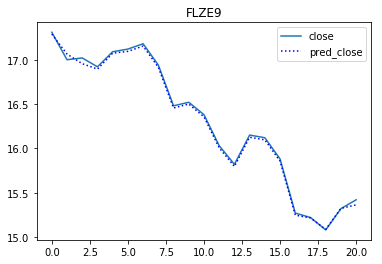

In [582]:
plt.plot(plot_data["close"], label='close')
plt.plot(plot_data["pred_close"], linestyle=':', c='blue', label='pred_close')
plt.title(str(plot_data["code"].values[0]))
plt.legend()

In [583]:
x_test, y_test = buildTest(random_code_5[4])
pred = model.predict(x_test)
plot_data = pick_plot_data(random_code_5[4])[len(pick_plot_data(random_code_5[4]))-len(x_test):len(pick_plot_data(random_code_5[4]))]
plot_data["return"] = pick_data_test(random_code_5[4])["return"][len(pick_plot_data(random_code_5[4]))-len(x_test)-1:len(pick_plot_data(random_code_5[4]))-1].values
plot_data.index = range(len(plot_data))
plot_data["pred"] = pred
plot_data["pred_check"] = (plot_data["close"]-plot_data["open"])/plot_data["open"]
plot_data["pred_close"] = plot_data["close"]*(1+plot_data["pred"])

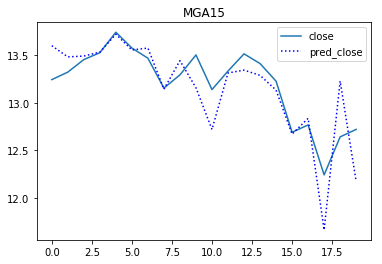

In [584]:
plt.plot(plot_data["close"], label='close')
plt.plot(plot_data["pred_close"], linestyle=':', c='blue', label='pred_close')
plt.title(str(plot_data["code"].values[0]))
plt.legend()

In [586]:
for i in range(len(random_code_5)):
    x_test, y_test = buildTest(random_code_5[i])
    pred = model.predict(x_test)
    plot_data = pick_plot_data(random_code_5[i])[len(pick_plot_data(random_code_5[i]))-len(x_test):len(pick_plot_data(random_code_5[i]))]
    plot_data["return"] = pick_data_test(random_code_5[i])["return"][len(pick_plot_data(random_code_5[i]))-len(x_test)-1:len(pick_plot_data(random_code_5[i]))-1].values
    plot_data.index = range(len(plot_data))
    plot_data["pred"] = pred
    plot_data["pred_check"] = (plot_data["close"]-plot_data["open"])/plot_data["open"]
    plot_data["pred_close"] = plot_data["close"]*(1+plot_data["pred"])
    
    plt.plot(plot_data["close"], label='close')
    plt.plot(plot_data["pred_close"], linestyle=':', c='blue', label='pred_close')
    plt.title(str(plot_data["code"].values[0]))
    plt.legend()
    plt.savefig(str(plot_data["code"].values[0]))
    plt.close('all')